<a href="https://colab.research.google.com/github/Dinillll/DL-Lab-08/blob/main/DQN_Gridworld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/Lab7part2.zip -d data

Archive:  /content/drive/MyDrive/Lab7part2.zip
   creating: data/Lab7(part2)/
   creating: data/Lab7(part2)/IT22298126/
  inflating: data/Lab7(part2)/IT22298126/DQN_Gridworld.ipynb  
  inflating: data/Lab7(part2)/IT22298126/LunarLander_DQN.ipynb  


In [ ]:
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
class GridWorld:
    ## Initialise starting data
    def __init__(self):
        # Set information about the gridworld
        self.height = 8
        self.width = 8
        self.grid = np.zeros(( self.height, self.width)) - 1

        # Set random start location for the agent
        self.current_location = ( 4, np.random.randint(0,5))

        # Set locations for the bomb and the gold
        self.bomb_location = (1,3)
        self.gold_location = (0,3)
        self.terminal_states = [ self.bomb_location, self.gold_location]

        # Set grid rewards for special cells
        self.grid[ self.bomb_location[0], self.bomb_location[1]] = -10
        self.grid[ self.gold_location[0], self.gold_location[1]] = 10

        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']


    ## Put methods here:
    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions

    def agent_on_map(self):
        """Prints out current location of the agent on the grid (used for debugging)"""
        grid = np.zeros(( self.height, self.width))
        grid[ self.current_location[0], self.current_location[1]] = 1
        return grid

    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[ new_location[0], new_location[1]]


    def make_step(self, action):
        """Moves the agent in the specified direction. If agent is at a border, agent stays still
        but takes negative reward. Function returns the reward for the move."""
        # Store previous location
        last_location = self.current_location

        # UP
        if action == 'UP':
            # If agent is at the top, stay still, collect reward
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # DOWN
        elif action == 'DOWN':
            # If agent is at bottom, stay still, collect reward
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # LEFT
        elif action == 'LEFT':
            # If agent is at the left, stay still, collect reward
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)

        # RIGHT
        elif action == 'RIGHT':
            # If agent is at the right, stay still, collect reward
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)

        return reward

    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb), if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

In [ ]:
class RandomAgent():
    # Choose a random action
    def choose_action(self, available_actions):
        """Returns a random choice of the available actions"""
        return np.random.choice(available_actions)

In [ ]:
class Q_Agent():
    # Intialise
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        self.environment = environment
        self.q_table = dict() # Store all Q-values in dictionary of dictionaries
        for x in range(environment.height): # Loop through all possible grid spaces, create sub-dictionary for each
            for y in range(environment.width):
                self.q_table[(x,y)] = {'UP':0, 'DOWN':0, 'LEFT':0, 'RIGHT':0} # Populate sub-dictionary with zero values for possible moves

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

    def choose_action(self, available_actions):
      if np.random.random() < self.epsilon:
          return np.random.choice(available_actions)
      state = self.environment.current_location
      q_values = self.q_table[state]
      max_value = max(q_values[a] for a in available_actions)
      best_actions = [a for a in available_actions if q_values[a] == max_value]
      return np.random.choice(best_actions)


    def learn(self, old_state, reward, new_state, action):
      current_q = self.q_table[old_state][action]
      if new_state in self.environment.terminal_states:
          max_future_q = 0
      else:
          max_future_q = max(self.q_table[new_state].values())
      self.q_table[old_state][action] += self.alpha * (
          reward + self.gamma * max_future_q - current_q
      )



In [ ]:
def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    """The play function runs iterations and updates Q-values if desired."""
    reward_per_episode = [] # Initialise performance log

    for trial in range(trials): # Run trials
        cumulative_reward = 0 # Initialise values of each game
        step = 0
        game_over = False
        while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
            old_state = environment.current_location
            action = agent.choose_action(environment.actions)
            reward = environment.make_step(action)
            new_state = environment.current_location

            if learn == True: # Update Q-values if learning is specified
                agent.learn(old_state, reward, new_state, action)

            cumulative_reward += reward
            step += 1

            if environment.check_state() == 'TERMINAL': # If game is in terminal state, game over and start next trial
                environment.__init__()
                game_over = True

        reward_per_episode.append(cumulative_reward) # Append reward for current trial to performance log

    return reward_per_episode # Return performance log

In [ ]:
env = GridWorld()
agent = RandomAgent()

print("Current position of the agent =", env.current_location)
print(env.agent_on_map())
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = agent.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)
reward = env.make_step(chosen_action)
print("Reward obtained =", reward)
print("Current position of the agent =", env.current_location)
print(env.agent_on_map())

Current position of the agent = (4, 0)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
Available_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
Randomly chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = (4, 0)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


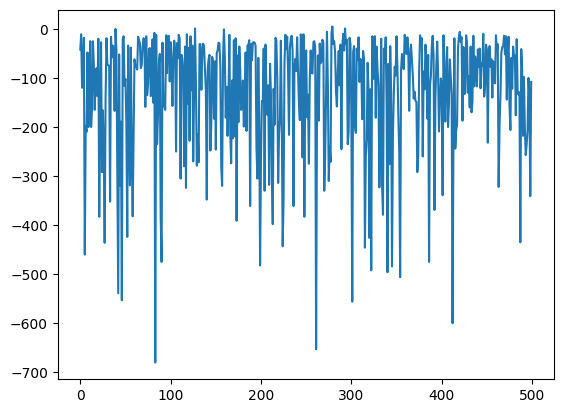

In [ ]:
# Initialize environment and agent
environment = GridWorld()
random_agent = RandomAgent()

reward_per_episode = play(environment, random_agent, trials=500)

# Simple learning curve
plt.plot(reward_per_episode)

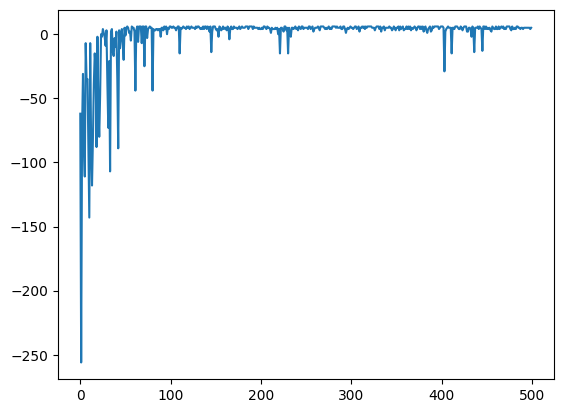

In [ ]:
environment = GridWorld()
agentQ = Q_Agent(environment)

# Note the learn=True argument!
reward_per_episode = play(environment, agentQ, trials=500, learn=True)

# Simple learning curve
plt.plot(reward_per_episode)

In [ ]:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))


pretty(agentQ.q_table)

(0, 0)
	UP
		-0.30000000000000004
	DOWN
		-0.3181
	LEFT
		-0.30000000000000004
	RIGHT
		0.19455893479530362
(0, 1)
	UP
		-0.2
	DOWN
		-0.11000000000000001
	LEFT
		-0.20927674288999998
	RIGHT
		6.44937619240922
(0, 2)
	UP
		4.161367265707597
	DOWN
		2.685526337311226
	LEFT
		2.343787063201379
	RIGHT
		9.999999999999993
(0, 3)
	UP
		0
	DOWN
		0
	LEFT
		0
	RIGHT
		0
(0, 4)
	UP
		-0.1
	DOWN
		0.8848866983527812
	LEFT
		9.999907386128688
	RIGHT
		-0.039195720999999996
(0, 5)
	UP
		-0.2
	DOWN
		-0.21
	LEFT
		1.4324576280585655
	RIGHT
		-0.209
(0, 6)
	UP
		-0.4
	DOWN
		-0.43439
	LEFT
		-0.33751000000000003
	RIGHT
		-0.40998100000000004
(0, 7)
	UP
		-0.5
	DOWN
		-0.5174610000000001
	LEFT
		-0.48982900000000007
	RIGHT
		-0.5
(1, 0)
	UP
		-0.5284200000000001
	DOWN
		-0.5540837721
	LEFT
		-0.5
	RIGHT
		-0.4990564049428109
(1, 1)
	UP
		-0.32599
	DOWN
		-0.30900000000000005
	LEFT
		-0.30000000000000004
	RIGHT
		4.548181612659064
(1, 2)
	UP
		8.999999999999986
	DOWN
		4.403864971444005
	LEFT
		0.826

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

# 1. Define Q-network architecture
class GridDQN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.layers(x)

# 2. one-hot encode a discrete state index
def one_hot_state(state_idx, num_states):
    vec = np.zeros(num_states, dtype=np.float32)
    vec[state_idx] = 1.0
    return vec

# 3. DQN Agent for gridworld
class DQNAgent:
    def __init__(self, num_states, num_actions,
                 gamma=1.0, lr=1e-3, epsilon=0.1):
        self.num_states = num_states
        self.num_actions = num_actions
        self.gamma = gamma
        self.epsilon = epsilon

        self.model = GridDQN(num_states, num_actions)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

    def select_action(self, state_idx, available_actions):
        # ε‑greedy action selection
        if random.random() < self.epsilon:
            return random.choice(available_actions)
        # Convert state index to one‑hot tensor and query network
        state_vec = one_hot_state(state_idx, self.num_states)
        with torch.no_grad():
            q_values = self.model(
                torch.tensor(state_vec).unsqueeze(0)
            )[0].numpy()
        # Choose the action with the highest Q‑value among available actions
        best_action = max(available_actions, key=lambda a: q_values[a])
        return best_action

    def train_step(self, old_state_idx, action, reward,
                   new_state_idx, done):
        # Encode states
        state_vec = one_hot_state(old_state_idx, self.num_states)
        state_tensor = torch.tensor(state_vec).unsqueeze(0)
        # Current Q-value for the taken action
        q_values = self.model(state_tensor)
        current_q = q_values[0, action]

        # Compute target Q-value using the Bellman update
        if done:
            target_q_value = torch.tensor(reward, dtype=torch.float32)
        else:
            next_state_vec = one_hot_state(new_state_idx, self.num_states)
            next_tensor = torch.tensor(next_state_vec).unsqueeze(0)
            with torch.no_grad():
                next_q_values = self.model(next_tensor)
            target_q_value = reward + self.gamma * torch.max(next_q_values)

        # Compute loss and backpropagate
        loss = self.loss_fn(current_q, target_q_value)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

# 4. Training loop
def train_dqn(env, agent, episodes=500):
    rewards_history = []
    for ep in range(episodes):
        # Assume env.reset() returns the starting state index
        state_idx = env.reset()
        done = False
        total_reward = 0
        while not done:
            # Get list of valid actions from the environment
            available_actions = env.get_available_actions()
            # Choose action via ε‑greedy
            action = agent.select_action(state_idx, available_actions)
            # Execute action and observe next state, reward, termination
            new_state_idx, reward, done, _ = env.step(action)
            # Train the network on this transition
            agent.train_step(state_idx, action, reward, new_state_idx, done)
            state_idx = new_state_idx
            total_reward += reward
        rewards_history.append(total_reward)
        # Optionally decay epsilon over time here if desired
        if (ep + 1) % 50 == 0:
            print(f'Episode {ep+1}, total reward: {total_reward}')
    return rewards_history

